Epoch 1/20 completed.
Epoch 2/20 completed.
Epoch 3/20 completed.
Epoch 4/20 completed.
Epoch 5/20 completed.
Epoch 6/20 completed.
Epoch 7/20 completed.
Epoch 8/20 completed.
Epoch 9/20 completed.
Epoch 10/20 completed.
Epoch 11/20 completed.
Epoch 12/20 completed.
Epoch 13/20 completed.
Epoch 14/20 completed.
Epoch 15/20 completed.
Epoch 16/20 completed.
Epoch 17/20 completed.
Epoch 18/20 completed.
Epoch 19/20 completed.
Epoch 20/20 completed.


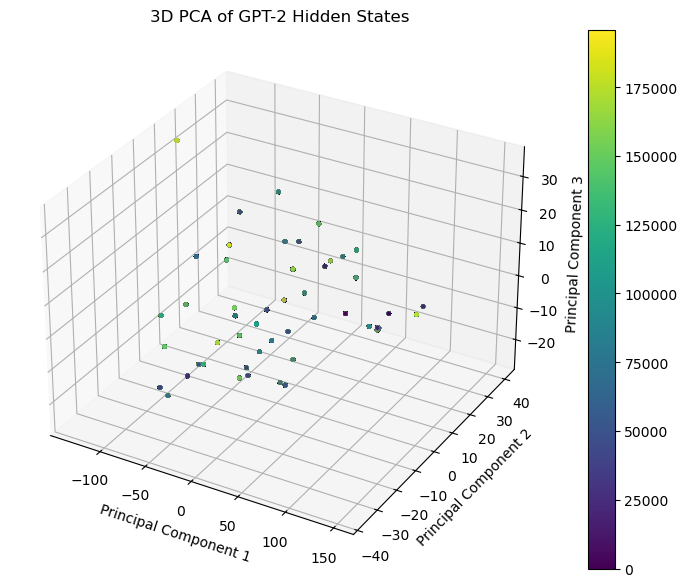

In [3]:
import torch
from transformers import GPT2Model, GPT2Tokenizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

def perform_pca_on_gpt2_large_dataset(model_name, texts, n_components=3, num_epochs=20, batch_size=10):
    """
    Perform PCA on the hidden states of a GPT-2 model for a large dataset over multiple epochs.

    Args:
    - model_name (str): Name of the pre-trained GPT-2 model from the transformers library.
    - texts (list of str): List of input texts to feed into the GPT-2 model.
    - n_components (int): Number of PCA components to reduce to (default is 3 for 3D visualization).
    - num_epochs (int): Number of epochs to iterate over the dataset.
    - batch_size (int): Number of texts to process in each batch.

    Returns:
    - pca_results (np.ndarray): Transformed PCA results of the hidden states.
    """

    # Load pre-trained GPT-2 model and tokenizer
    model = GPT2Model.from_pretrained(model_name)
    tokenizer = GPT2Tokenizer.from_pretrained(model_name)

    # Set model to evaluation mode
    model.eval()

    all_hidden_states = []

    for epoch in range(num_epochs):
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i + batch_size]
            batch_hidden_states = []

            for text in batch_texts:
                # Tokenize input text
                inputs = tokenizer(text, return_tensors='pt')

                # Get hidden states from the GPT-2 model
                with torch.no_grad():
                    outputs = model(**inputs, output_hidden_states=True)
                    hidden_states = outputs.hidden_states  # A tuple with layers of hidden states

                # Select the last hidden state (which is the output of the last transformer block)
                last_hidden_state = hidden_states[-1]  # Shape: (batch_size, sequence_length, hidden_size)

                # Convert the tensor to numpy array
                hidden_state_np = last_hidden_state.squeeze().cpu().numpy()

                # Flatten the sequence dimension into the batch dimension for PCA
                hidden_state_flat = hidden_state_np.reshape(-1, hidden_state_np.shape[-1])

                # Accumulate the hidden states for this batch
                batch_hidden_states.append(hidden_state_flat)

            # Concatenate hidden states for the batch
            batch_hidden_states = np.concatenate(batch_hidden_states, axis=0)
            all_hidden_states.append(batch_hidden_states)

        print(f"Epoch {epoch + 1}/{num_epochs} completed.")

    # Concatenate all hidden states from all epochs and batches
    all_hidden_states = np.concatenate(all_hidden_states, axis=0)

    # Perform PCA
    pca = PCA(n_components=n_components)
    pca_results = pca.fit_transform(all_hidden_states)

    # Plot the PCA results if n_components is 3
    if n_components == 3:
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(pca_results[:, 0], pca_results[:, 1], pca_results[:, 2], 
                             c=np.arange(pca_results.shape[0]), cmap='viridis', s=5)
        fig.colorbar(scatter)
        ax.set_xlabel('Principal Component 1')
        ax.set_ylabel('Principal Component 2')
        ax.set_zlabel('Principal Component 3')
        ax.set_title('3D PCA of GPT-2 Hidden States')
        plt.show()

    return pca_results

# Example usage:
model_name = 'gpt2'
# Generate a large dataset by repeating a set of example sentences
example_sentences = [
    "The quick brown fox jumps over the lazy dog.",
    "Another example sentence to process.",
    "This is a sentence used for testing purposes.",
    "GPT-2 is a powerful language model developed by OpenAI.",
    "Deep learning techniques have revolutionized natural language processing."
]
texts = example_sentences * 200  # Create a large dataset by repeating example sentences
num_epochs = 20
batch_size = 10
pca_results = perform_pca_on_gpt2_large_dataset(model_name, texts, n_components=3, num_epochs=num_epochs, batch_size=batch_size)
